In [188]:
import os
from time import time
import pandas as pd
import xgboost as xgb
from config import TEST_SPLIT_PERCENTAGE, RANDOM_STATE, RANDOM_CV_SPLIT
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from helper import expand_contractions, read_data
import matplotlib.pyplot as plt

label_encoder = LabelEncoder()

cv_strategy = StratifiedKFold(n_splits=RANDOM_CV_SPLIT, shuffle=True, random_state=RANDOM_STATE)

df = read_data()
df['label'] = label_encoder.fit_transform(df['punctuation'])

In [178]:
# Train/Test split
df_train, df_test = train_test_split(df, test_size=TEST_SPLIT_PERCENTAGE, stratify=df['label'], random_state=RANDOM_STATE)

In [179]:
# Two cleaning classes:
#* SimpleCleaningTransformer - a simple transformer (lowercase and character removal)
#* StopWordsRemovalTransformer - in addition to simple cleaning, there is stop word removal.

class SimpleCleaningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Ensure X is a pandas Series
        if not isinstance(X, pd.Series):
            raise ValueError(f"Input should be a pandas Series.{type(X)}, {X.shape}")
        
        # Apply cleaning operations
        X_cleaned = X.str.lower()  # Convert to lowercase
        X_cleaned = X_cleaned.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Remove punctuation but keep numbers
        X_cleaned = X_cleaned.str.strip()  # Remove leading/trailing whitespace

        X_no_empty = [ EMPTY_TOKEN if row == '' else row for row in X_cleaned]
        
        return X_no_empty

class StopWordsRemovalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Ensure X is a pandas Series
        if not isinstance(X, pd.Series):
            raise ValueError(f"Input should be a pandas Series.{type(X)}, {X.shape}")

        # Apply cleaning operations
        X_cleaned = X.str.lower()  # Convert to lowercase
        X_cleaned = X_cleaned.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Remove punctuation but keep numbers
        X_cleaned = X_cleaned.str.strip()  # Remove leading/trailing whitespace

        X_no_stop_words = [' '.join([word for word in row.split() if word not in ENGLISH_STOP_WORDS]) for row in X_cleaned]
        X_no_stop_words_no_empty = [ EMPTY_TOKEN if row == '' else row for row in X_no_stop_words]

        return X_no_stop_words_no_empty

In [180]:
# vocabulary_dict = None
pipeline = Pipeline(steps=[("cleaning","tmp_cleaner"),
                           ("bow", CountVectorizer()),
                           ("tfidf", TfidfTransformer()),
                           ('classifier', AdaBoostClassifier())])

# Bootstrap aggregating
RandomForestClassifier_param = {'cleaning': [SimpleCleaningTransformer(), StopWordsRemovalTransformer()],
                                'classifier': [RandomForestClassifier()],
                                'classifier__n_estimators': [100],
                                'classifier__max_depth': [10],
                                'classifier__class_weight': ['balanced'],
                                'classifier__min_samples_split': [2],
                                'classifier__random_state': [RANDOM_STATE]}
# AdaBoost
AdaBoost_param = {'cleaning': [SimpleCleaningTransformer(), StopWordsRemovalTransformer()],
                  'classifier': [AdaBoostClassifier(algorithm='SAMME')], #DecisionTree
                  'classifier__n_estimators': [100, 200],
                  'classifier__learning_rate': [0.1, 1],
                  'classifier__random_state': [RANDOM_STATE]}

# XGBoost
XGBClassifier_param = {'cleaning': [SimpleCleaningTransformer(), StopWordsRemovalTransformer()],
                       'classifier': [xgb.XGBClassifier()],
                       'classifier__eta': [0.1],
                       'classifier__gamma': [1.5],
                       'classifier__max_depth': [6],
                       'classifier__subsample': [1.0],
                       'classifier__min_child_weight': [1.0],
                       'classifier__eval_metric': ['mlogloss'],
                       'classifier__seed': [RANDOM_STATE]}

params = [AdaBoost_param, XGBClassifier_param, RandomForestClassifier_param]

gs = GridSearchCV(pipeline, param_grid=params, refit='f1', return_train_score=True, cv=cv_strategy, n_jobs=-1, scoring='f1_micro')

In [182]:
tic = time()
print('df_train shape:',df_train.shape)
gs.fit(df_train['t_uncontraction'], df_train['label'])
toc = time()
print(f'GridSearchCV time(mintues): {round((toc-tic)/60,2)}')

best_params = gs.best_params_

df_train shape: (912, 8)
GridSearchCV time(mintues): 0.3


In [183]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__learning_rate,param_classifier__n_estimators,param_classifier__random_state,param_cleaning,param_classifier__eta,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.300786,0.165730,0.021133,0.000733,AdaBoostClassifier(algorithm='SAMME'),0.1,100.0,42.0,SimpleCleaningTransformer(),NaN,...,0.586627,0.001574,4,0.587106,0.587106,0.586301,0.586301,0.586301,0.586623,0.000394
1,0.167058,0.004213,0.019768,0.000474,AdaBoostClassifier(algorithm='SAMME'),0.1,100.0,42.0,StopWordsRemovalTransformer(),NaN,...,0.586627,0.001574,4,0.587106,0.587106,0.591781,0.586301,0.586301,0.587719,0.002063
2,0.569630,0.218006,0.060925,0.044468,AdaBoostClassifier(algorithm='SAMME'),0.1,200.0,42.0,SimpleCleaningTransformer(),NaN,...,0.592104,0.006587,2,0.599451,0.592593,0.597260,0.597260,0.586301,0.594573,0.004703
3,0.344401,0.015790,0.040192,0.006293,AdaBoostClassifier(algorithm='SAMME'),0.1,200.0,42.0,StopWordsRemovalTransformer(),NaN,...,0.586627,0.003815,4,0.587106,0.587106,0.593151,0.586301,0.586301,0.587993,0.002604
4,0.195026,0.007669,0.020461,0.001131,AdaBoostClassifier(algorithm='SAMME'),1.0,100.0,42.0,SimpleCleaningTransformer(),NaN,...,0.589906,0.017239,3,0.591221,0.603567,0.602740,0.609589,0.595890,0.600601,0.006393
5,0.178330,0.011462,0.019934,0.001028,AdaBoostClassifier(algorithm='SAMME'),1.0,100.0,42.0,StopWordsRemovalTransformer(),NaN,...,0.582237,0.007165,8,0.587106,0.585734,0.600000,0.604110,0.597260,0.594842,0.007227
6,0.395380,0.030053,0.035920,0.001316,AdaBoostClassifier(algorithm='SAMME'),1.0,200.0,42.0,SimpleCleaningTransformer(),NaN,...,0.584435,0.013835,7,0.598080,0.614540,0.610959,0.612329,0.600000,0.607182,0.006773
7,0.321024,0.007766,0.033701,0.000724,AdaBoostClassifier(algorithm='SAMME'),1.0,200.0,42.0,StopWordsRemovalTransformer(),NaN,...,0.582231,0.008274,9,0.585734,0.592593,0.598630,0.605479,0.600000,0.596487,0.006762
8,0.143572,0.003356,0.005879,0.000349,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,SimpleCleaningTransformer(),0.1,...,0.594295,0.016299,1,0.713306,0.716049,0.704110,0.720548,0.712329,0.713268,0.005394
9,0.062623,0.003065,0.005837,0.000322,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,NaN,StopWordsRemovalTransformer(),0.1,...,0.580028,0.009571,10,0.617284,0.618656,0.624658,0.639726,0.641096,0.628284,0.010217


In [184]:
best_model = gs.best_estimator_
best_model

Pipeline(steps=[('cleaning', SimpleCleaningTransformer()),
                ('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.1,
                               eval_metric='mlogloss', feat...es=None,
                               gamma=1.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=1.0, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [203]:
df_test['predictions'] = best_model.predict(df_test['t_uncontraction'])
f1_macro =  f1_score(df_test['label'], df_test['predictions'], average='macro')

print(f'F1 Test Score: {f1_macro}')

F1 Test Score: 0.37567844342037887


### check each label, F1 score

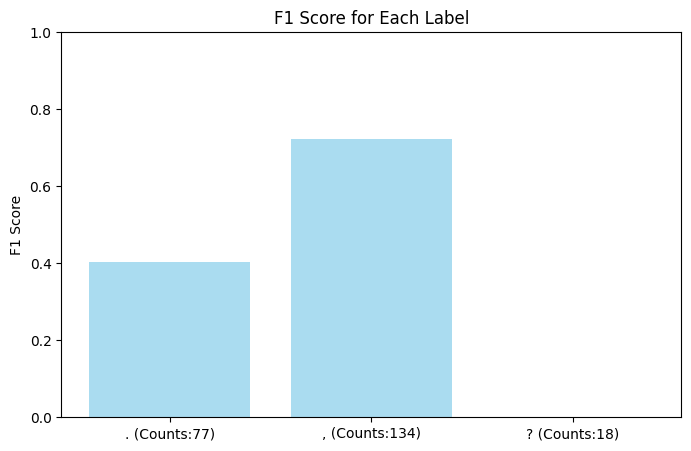

In [233]:
labels = df_test['punctuation'].unique()

f1_scores = []
x_labels = []

for label in labels:
    label_number = label_encoder.transform([label])[0]
    f1 = f1_score(df_test['punctuation'] == label, df_test['predictions'] == label_number)
    f1_scores.append(f1)
    x_labels.append(str(label) + ' (Counts:' + str(sum(df_test['label'] == label_number)) +')')

plt.figure(figsize=(8, 5))
plt.bar(x_labels, f1_scores, color='skyblue', alpha=0.7)

plt.ylim(0, 1) 
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Label')

# Show the plot
plt.show()

# Discussion and conclusion

1. Since there is F1=0 for '?' the max F1 Macro that we can get is 66%.
2. Since there are only 18 samples in the test set for '?' and the score is zero. We need to rethink about the the equal relevance for each category.
3. Instead of F1-macro on the imbalanced data we can use SMOTE and balance the data set.
4. Instead of simple tf-idf we can use embedding to get better prediction.
5. The test score of F1 = 0.38 is a good baseline for further investigation.